# Sklearn Pipeline for Scoring New Data

In [1]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import gower
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cluster Explainability
import shap

# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
# load the local dataset 
df = pd.read_csv('../data/adult_dataset.csv')

In [3]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

# Correct the Income column typo
df['Income'] = df['Income'].apply(lambda x: x.replace('.', ''))

# Load Model Artifacts

In [5]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/categorical_imputer.pickle', 'rb') as filename: # trained model to impute missing categorical data
    categorical_imputer = pickle.load(filename) 

with open('../artifacts/rare_encoder.pickle', 'rb') as filename: # trained model to encode rare labels
    rare_encoder = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/enc.pickle', 'rb') as filename: # trained one hot encoder
    enc = pickle.load(filename)

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

# Transform Dataset

In [6]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()
categorical_columns = df.select_dtypes(exclude=numerics).columns.to_list()

In [7]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

# impute mising categorical features
df_categorical = pd.DataFrame(
    categorical_imputer.transform(df[categorical_columns]), 
    columns=categorical_columns, 
    index=df.index)

# concate numeric and categorical features
df = pd.concat([df_numeric, df_categorical], axis=1)

# remove rare labels
df[categorical_columns] = rare_encoder.transform(df[categorical_columns])

# remove outliers
df[numeric_columns] = capper.transform(df[numeric_columns])

# one hot encoding categorical features
df_cat_hotenc = pd.DataFrame(
    enc.transform(df[categorical_columns]), 
    columns=enc.get_feature_names_out(),
    index=df.index) 

# concate numeric and hot-encoded categorical features
df_hotenc = pd.concat([df[numeric_columns], df_cat_hotenc], axis=1)

# predict cluster
labels = model.predict(df_hotenc)

# add cluster label to df
df['cluster'] = labels

df.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
0,39.0,77516.0,13.0,2174.0,0.0,40.0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,Private,HS-grad,Divorced,Rare,Not-in-family,White,Male,United-States,<=50K,2
3,53.0,234721.0,7.0,0.0,0.0,40.0,Private,Rare,Married-civ-spouse,Rare,Husband,Black,Male,United-States,<=50K,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Rare,<=50K,0


# Data Visualization

In [8]:
np.sort(df['cluster'].unique())

array([0, 1, 2, 3], dtype=int64)

<AxesSubplot:xlabel='cluster', ylabel='Count'>

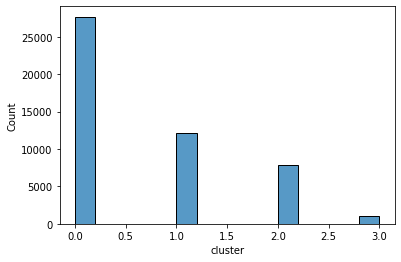

In [9]:
sns.histplot(
    data=df, 
    x='cluster',
    bins=15
)

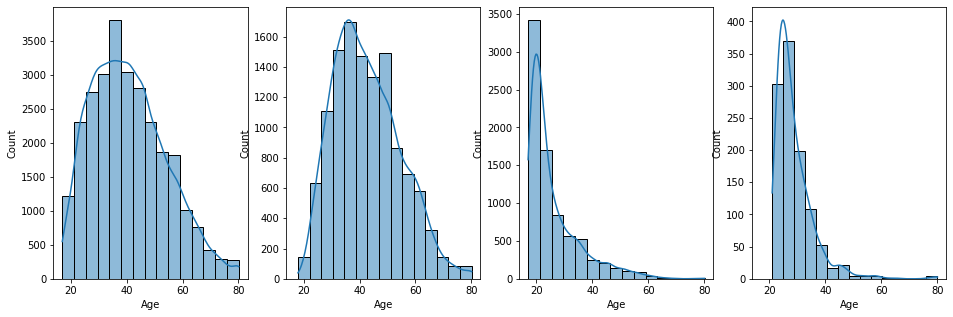

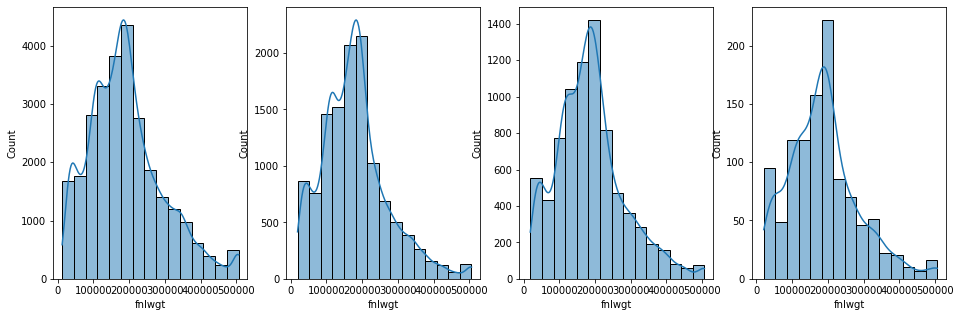

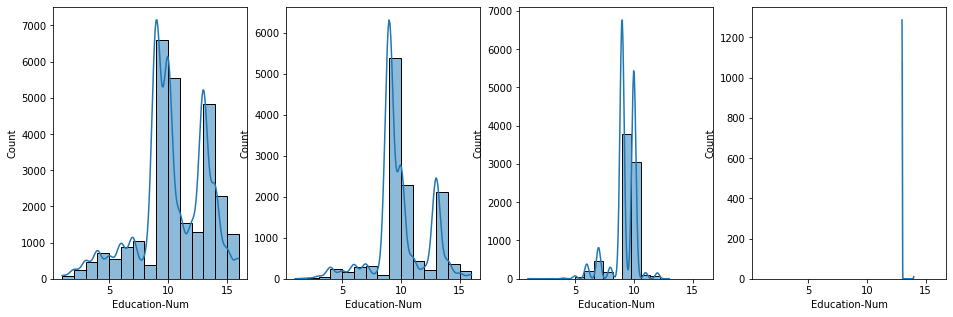

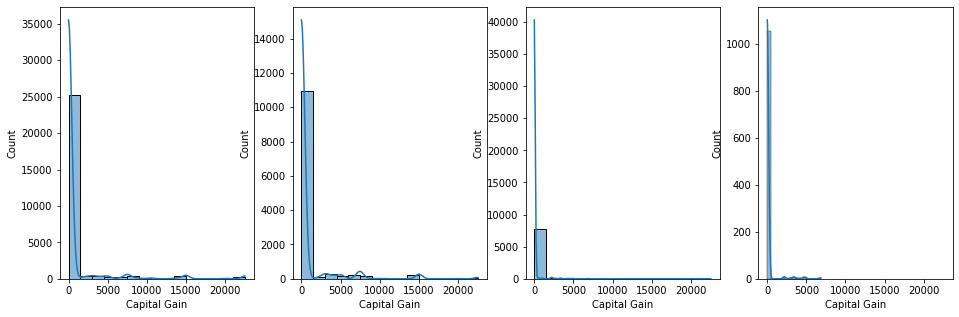

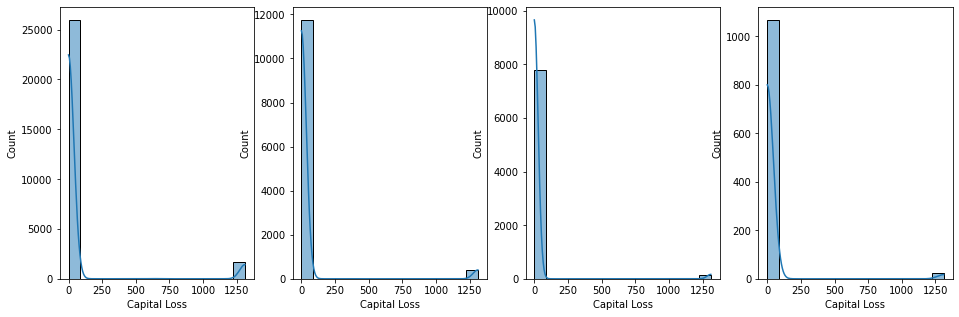

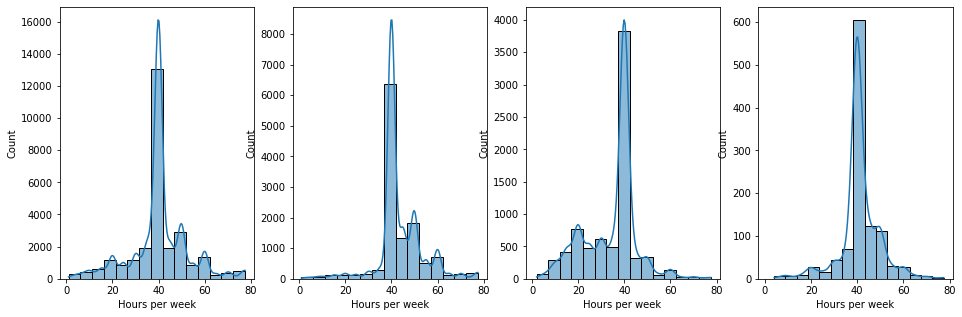

In [10]:
# visualize numeric features for each cluster
for feat in numeric_columns:

    fig, ax = plt.subplots(
        figsize=(16,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            bins=15,
            kde=True,
            ax=ax[c])
    plt.show()

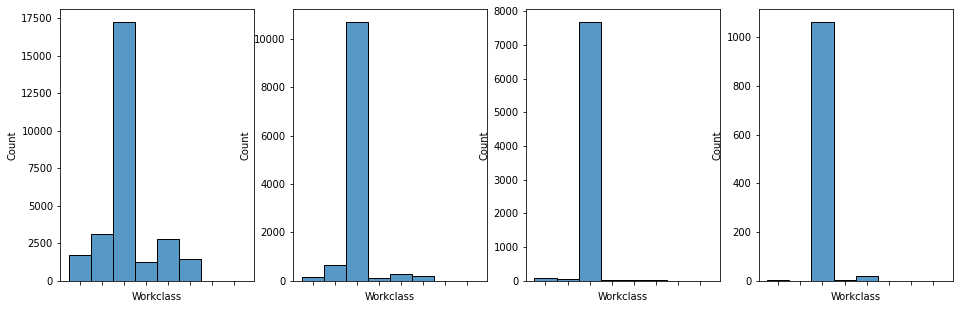

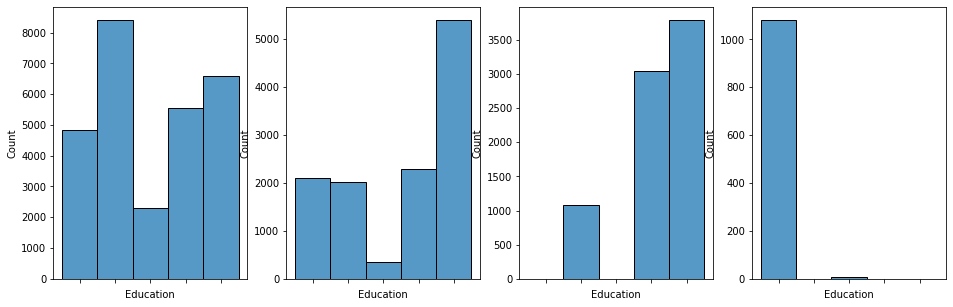

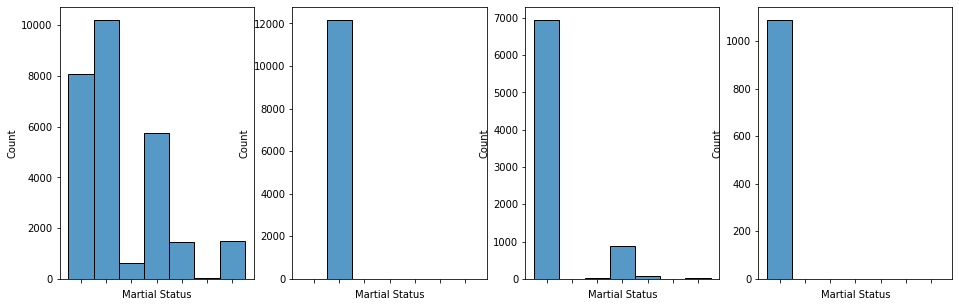

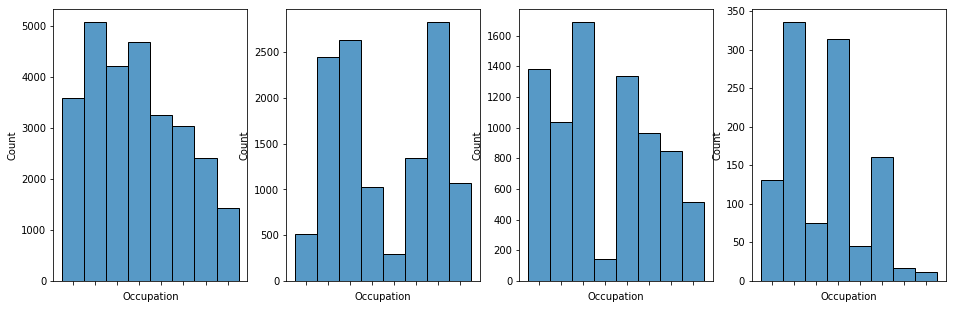

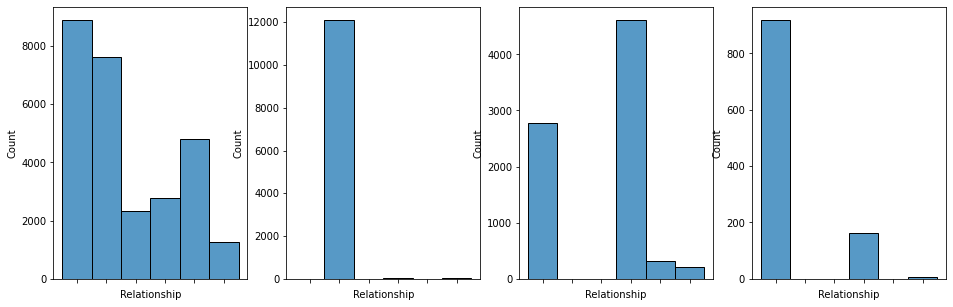

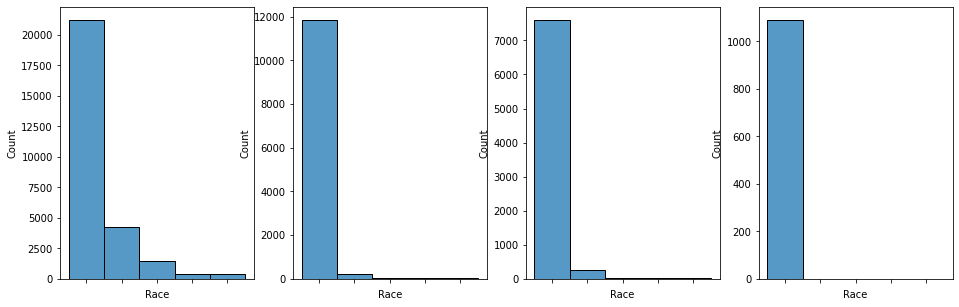

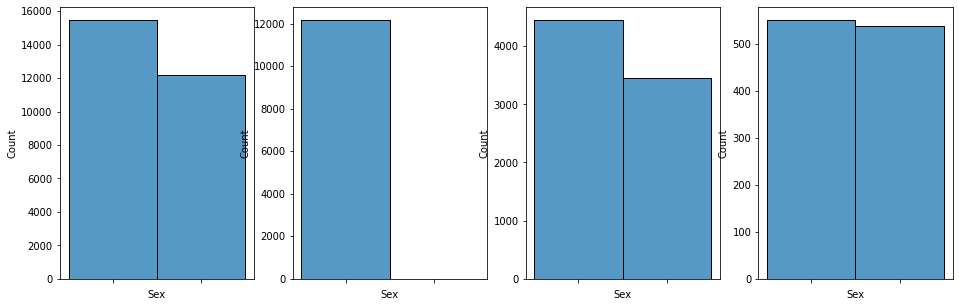

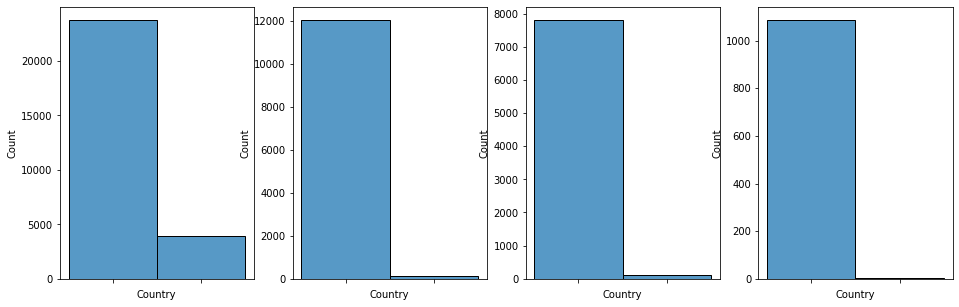

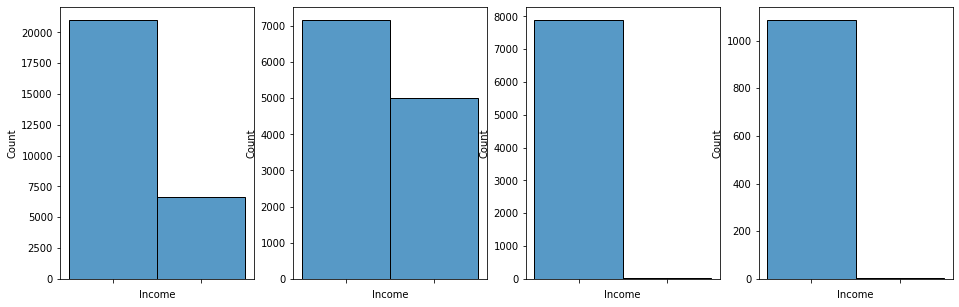

In [11]:
# visualize categorical features for each cluster
for feat in categorical_columns:

    fig, ax = plt.subplots(
        figsize=(16,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            ax=ax[c])
        ax[c].set_xticks(ax[c].get_xticks(), ax[c].get_xticklabels(), rotation=90)
        
    plt.show()

# Explain Clusters

In [12]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_, 
    output = 'probability')

In [13]:
#df_hotenc.iloc[:100,:]
df_hotenc[:100]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male,Country_United-States,Income_>50K
0,39.0,77516.0,13.0,2174.0,0.000000,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,50.0,83311.0,13.0,0.0,0.000000,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,38.0,215646.0,9.0,0.0,0.000000,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,53.0,234721.0,7.0,0.0,0.000000,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,28.0,338409.0,13.0,0.0,0.000000,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,29.0,115585.0,10.0,0.0,0.000000,50.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
96,48.0,191277.0,16.0,0.0,1311.126399,60.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
97,37.0,202683.0,10.0,0.0,0.000000,48.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
98,48.0,171095.0,12.0,0.0,0.000000,40.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
X = df_hotenc.sample(100)
shap_values = explainer.shap_values(X)

In [15]:
shap_values

[array([[ 0.00150583, -0.02385617, -0.00231049, ..., -0.0783619 ,
         -0.03144478,  0.0010603 ],
        [-0.00684733, -0.02397732, -0.01249038, ..., -0.07906581,
         -0.04331206, -0.02468366],
        [-0.08415263, -0.01749182, -0.04622757, ..., -0.01590564,
         -0.0195158 , -0.0149365 ],
        ...,
        [ 0.08899246,  0.02914057,  0.07073883, ...,  0.12496216,
         -0.01511822, -0.00996313],
        [ 0.00935205,  0.01706772, -0.0127011 , ...,  0.16259376,
         -0.00948198, -0.00306835],
        [-0.0028416 , -0.00802886,  0.06865674, ..., -0.00811695,
         -0.01300317, -0.00465103]]),
 array([[ 0.02113381,  0.02035749,  0.0140261 , ...,  0.08265346,
          0.02864621,  0.03135657],
        [ 0.00384814,  0.018278  ,  0.02028057, ...,  0.08191495,
          0.03798265,  0.0196178 ],
        [-0.02637762,  0.00440463,  0.00222499, ...,  0.01970777,
          0.00517954, -0.00431577],
        ...,
        [ 0.00119426,  0.0033285 , -0.00313235, ..., -

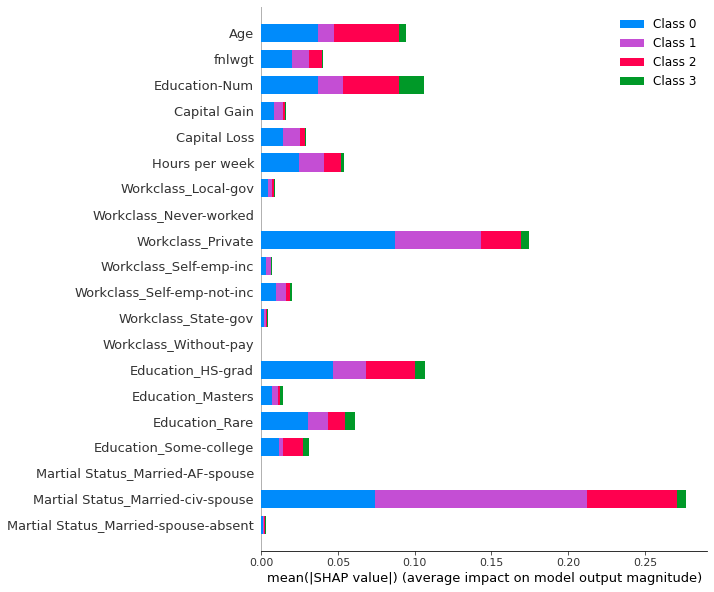

In [16]:
shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=False,
    plot_size=(8.0,10.0)
    )

# Explain Single Class Decision

In [17]:
shap_values[1]

array([[ 0.02113381,  0.02035749,  0.0140261 , ...,  0.08265346,
         0.02864621,  0.03135657],
       [ 0.00384814,  0.018278  ,  0.02028057, ...,  0.08191495,
         0.03798265,  0.0196178 ],
       [-0.02637762,  0.00440463,  0.00222499, ...,  0.01970777,
         0.00517954, -0.00431577],
       ...,
       [ 0.00119426,  0.0033285 , -0.00313235, ..., -0.07910585,
         0.00442912, -0.00269572],
       [ 0.00888733, -0.01482938,  0.00787916, ..., -0.17224064,
         0.00637   , -0.00097803],
       [ 0.00155405,  0.00517688, -0.02165136, ...,  0.01590417,
         0.00649658, -0.00587441]])

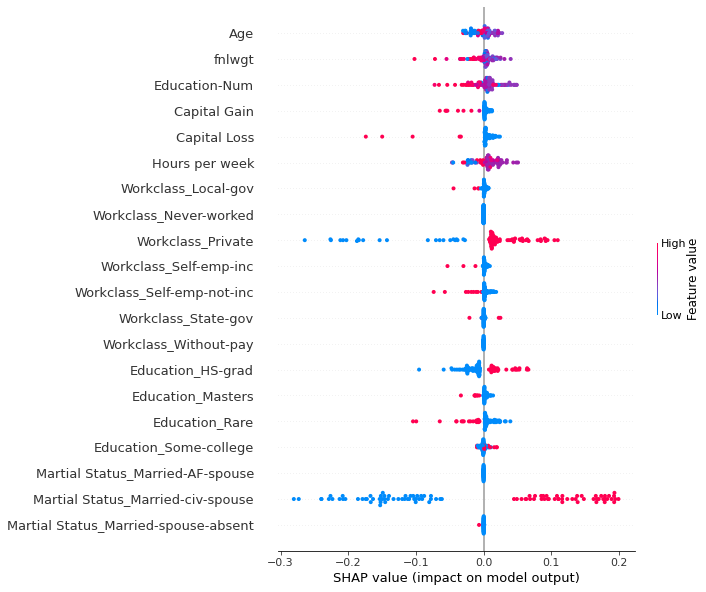

In [18]:
shap.summary_plot(
    shap_values = shap_values[1], 
    features = X,
    sort=False,
    plot_size=(8.0,10.0)
    )

# Explain Single Prediction

In [19]:
explainer.expected_value

array([0.56508015, 0.24776296, 0.16253188, 0.02462501])

In [20]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value[1], 
    shap_values = shap_values[1][0,:], 
    features = X.iloc[0,:],
    matplotlib = False,
    figsize=(18, 9)
    )